In [3]:
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

# Загрузка данных

#### Загрузить словарь данных, содержащихся в массиве показателей

In [4]:
# Импорт названий листов с данными
sheets = pd.read_csv('./data/sheets.txt', header=None).values.T[0].tolist()

# Импорт названий столбцов на соответствующих листах
sheets_columns = pd.read_csv('./data/sheets columns.txt', header=None, sep='\t').values

# Словарь-  лист: названия столбцов на листе
sname = dict((sheet,values.tolist()) for sheet,values in zip(sheets,sheets_columns))

In [5]:
# Информация по отчетам
earns = pd.read_csv('./data/earns.csv', low_memory=False)

# Логарифмические доходности
edata_before_adj_logret = pd.read_csv('./data/edata_before_adj_logret.csv', index_col=None, header=None).values
edata_after_adj_logret = pd.read_csv('./data/edata_after_adj_logret.csv', index_col=None, header=None).values
market_before_logret = pd.read_csv('./data/market_before_logret.csv', index_col=None, header=None).values
market_after_logret = pd.read_csv('./data/market_after_logret.csv', index_col=None, header=None).values

# Вектор бет
beta_ = pd.read_csv('./data/beta_before_adj.csv', index_col=None, header=None, skip_blank_lines=False).values

# Abnormal return 
edata_before_abn = edata_before_adj_logret - market_before_logret*beta_
edata_after_abn = edata_after_adj_logret - market_after_logret*beta_

edata_before_abn.shape, edata_after_abn.shape

((38239, 199), (38239, 40))

## Функция для отрисовки heatmap
Если указана alpha (уровень значимости) матрица p_val заменяется 1 если нулевая гипотезу принимаем, и 0 в другом случае

In [6]:
def plot_heat(data, alpha=None, title='', n_examples=None, savefig=False, prename='', cmap='Greens'):
    
    # Если все значения nan, заполнить массив нулями
    if data.isnull().all().all():
        data[:]=0
        
    # Если указана альфа - заполнить нулями и единицами
    if alpha is not None:
        for a_,a in zip(alpha[:-1], alpha[1:]):
            data[(data>a_)&(data<=a)] = a
        data[data>alpha[-1]] = 1

    fig, ax = plt.subplots(figsize=(24, 12))
    sns.heatmap(data, vmin=0, vmax=1, cmap=cmap, linewidths=0.05, linecolor='silver', square=True)
    
    # Заголовок. Добавить колв-во наблюдений если указано
    if n_examples is not None: title += ' (наблюдений: ' + str(n_examples) + ')'
    ax.set_title(title, fontsize=24)
    
    # Сохранить
    if savefig:
        # Добавить пробел после prename
        if len(prename)!=0: prename=prename+' '
        
        # Сохранить
        fig.savefig(prename + title.replace(':','') + '.png', bbox_inches='tight', pad_inches=0.6)

## Выбор показателей и ситуации для отображения

In [7]:
# Для хранения всех фильтраций
filter_ = pd.DataFrame()

# Для хранения всех заголовков графиков
title = []

for show_for in sname.keys():

    # Столбцы показателя
    vals_name = sname[show_for]
    act_value = [s for s in vals_name if 'ActValue' in s][0]
    mean_value = [s for s in vals_name if 'Mean' in s][0]

    # Разница актуального с ожидаемым
    shock_dif = earns[act_value] - earns[mean_value]

    # Показатель объявлен выше ожидаемого значения
    filter_ = pd.concat([filter_, shock_dif>0], axis=1)
    title.append(show_for + ': показатель выше ожидаемого')

    # Показатель объявлен ниже ожидаемого значения
    filter_ = pd.concat([filter_, shock_dif<0], axis=1)
    title.append(show_for + ': показатель ниже ожидаемого')

# Проверка гипотез
#### H0: средние доходности равны нулю против
- H1: средние доходности не равны нулю
- H1: средние доходности выше нуля
- H1: средние доходности ниже нуля


#### Параметры и индексы для переменных

In [8]:
# Количество дней до и после события
days_before = 10
days_after = 10

# Удвоенный массив показателей
double_sname = np.array([val for val in list(sname.keys()) for _ in (0, 1)], dtype='object')

# К каждому четному приписать слово above
double_sname[::2] += ' (above)'

# К каждому нечетному приписать слово below
double_sname[1::2] += ' (below)'

# Колонки
columns = np.concatenate([np.arange(-days_before,0),np.arange(0, days_after+1)])
columns_cum = np.concatenate([np.arange(-days_before,0),np.arange(1, days_after+1)])

## Накопленная избыточная доходность от event line
Куммулятивные доходности считаются накоплением от дня события. Первый день после выхода события убран из расчета куммулятивной доходности по понятным причинам (геп практически всегда и это можно принимать не отклонение от нормальной доходности, а корректировкой цены акции)

In [10]:
# Преаллокация массива для записи p-values
p_vals_event = pd.DataFrame(index=double_sname, columns=columns_cum, dtype='float')

# Массив для записи t-статистики
t_stats_event = pd.DataFrame(index=double_sname, columns=columns_cum, dtype='float')

for f in range(filter_.shape[1]):
    for n in p_vals_event.columns:
        if n<0:
            rets = np.sum(edata_before_abn[filter_.iloc[:,f]][:,n:], axis=1)

        elif n>0:
            rets = np.sum(edata_after_abn[filter_.iloc[:,f]][:,1:n+1], axis=1)
            
        # Убрать Nan
        rets = rets[~np.isnan(rets)]

        p_vals_event.loc[double_sname[f], n] = round(stats.ttest_1samp(rets, 0).pvalue,4)
        t_stats_event.loc[double_sname[f], n] = round(stats.ttest_1samp(rets, 0).statistic,4)

# H1: Greater than 0
p_vals_event_greater = p_vals_event.copy()
p_vals_event_greater[t_stats_event>0] = p_vals_event_greater/2
p_vals_event_greater[t_stats_event<=0] = 1-p_vals_event_greater/2

# H1: Less than 0
p_vals_event_less = p_vals_event.copy()
p_vals_event_less[t_stats_event<0] = p_vals_event_less/2
p_vals_event_less[t_stats_event>=0] = 1-p_vals_event_less/2

## Избыточная доходность
На каждый день исследуемого интервала проверяются гипотезы о средней избыточной доходности

In [46]:
# объединить доходности в один массив
all_rets = np.concatenate((edata_before_abn[:,-days_before:], edata_after_abn[:, :days_after+1]), axis=1)

# Преаллокация массива для записи p-values
p_vals = pd.DataFrame(index=double_sname, columns=columns, dtype='float')

# Массив для записи t-статистики
t_stats = pd.DataFrame(index=double_sname, columns=columns, dtype='float')

for f in range(filter_.shape[1]):
    for n in range(p_vals.shape[1]):
        
        # Столбец куммулятивных доходностей на день номер n с учетом фильтра
        rets = all_rets[filter_.iloc[:,f]][:,n].copy()
        
        # Убрать Nan
        rets = rets[~np.isnan(rets)]

        p_vals.loc[double_sname[f]].iloc[n] = round(stats.ttest_1samp(rets, 0).pvalue,4)
        t_stats.loc[double_sname[f]].iloc[n]  = round(stats.ttest_1samp(rets, 0).statistic,4)
        
# H1: Greater than 0
p_vals_greater = p_vals.copy()
p_vals_greater[t_stats>0] = p_vals_greater/2
p_vals_greater[t_stats<=0] = 1-p_vals_greater/2

# H1: Less than 0
p_vals_less = p_vals.copy()
p_vals_less[t_stats<0] = p_vals_less/2
p_vals_less[t_stats>=0] = 1-p_vals_less/2

# Построение графики
Заливка - принятие нулевой гипотезы о том, что средние абнормальные доходности равны нулю (на заданном уровне значимости alpha)

Светлая заливка - отклонение нулевой гипотезы в пользу альтернативной.

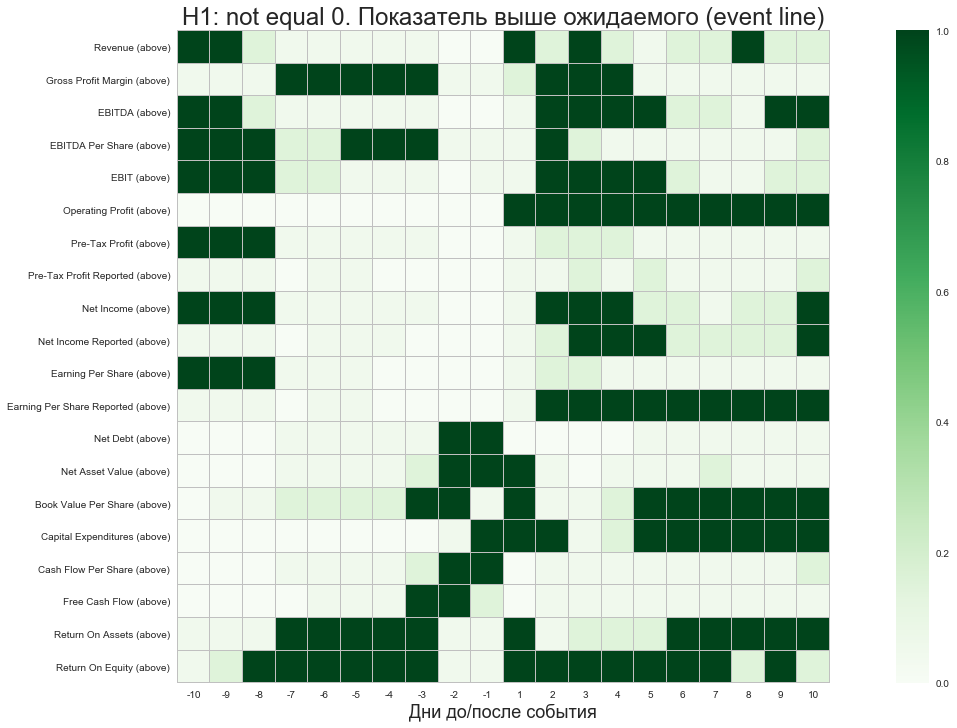

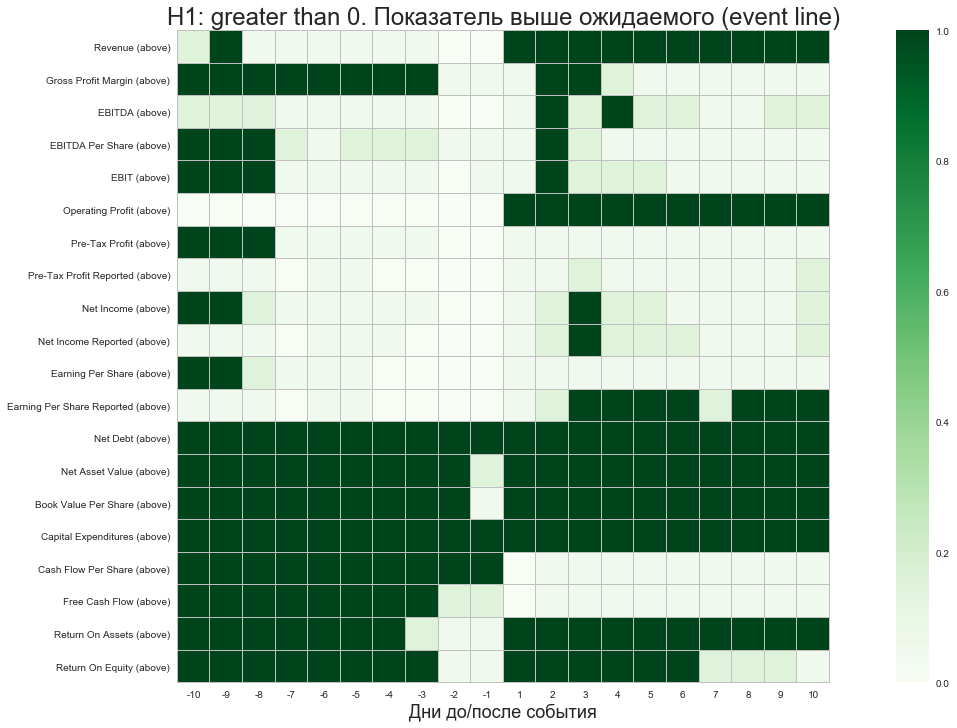

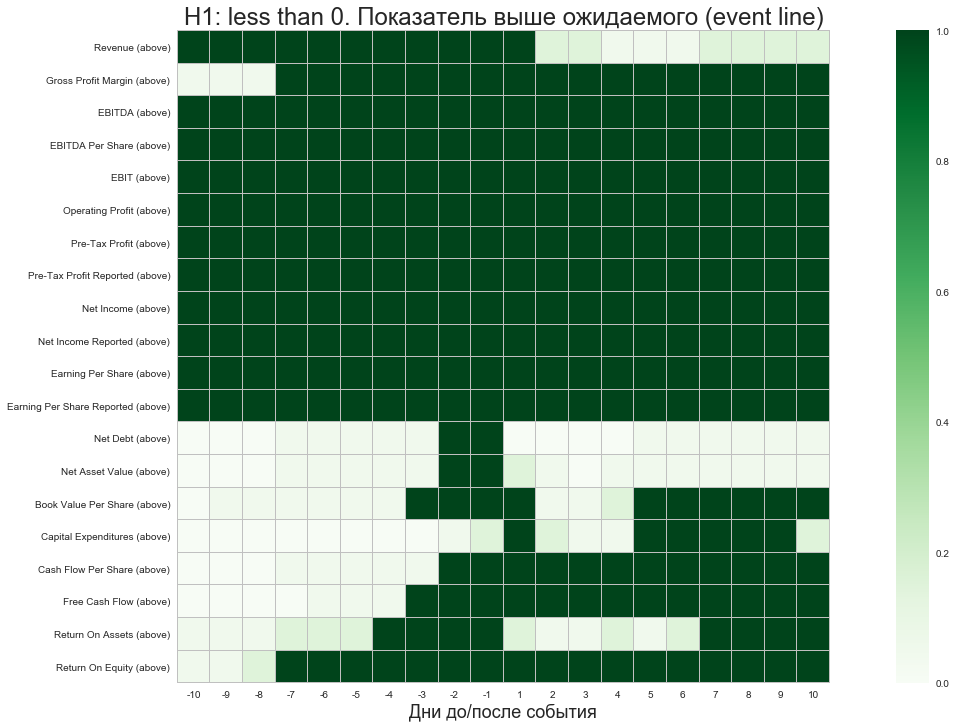

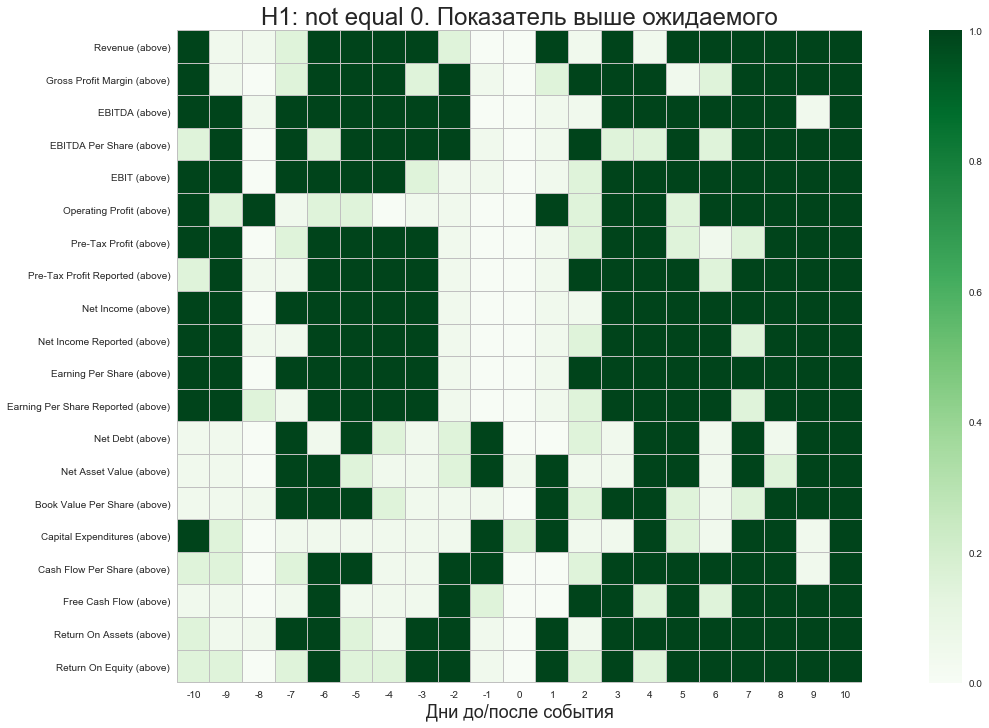

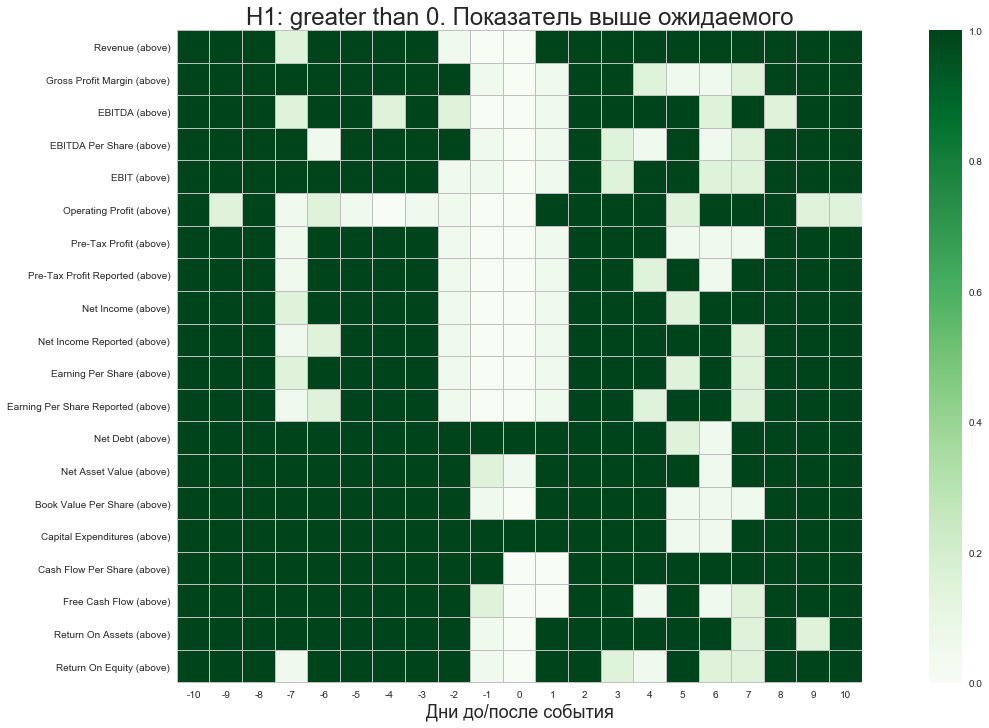

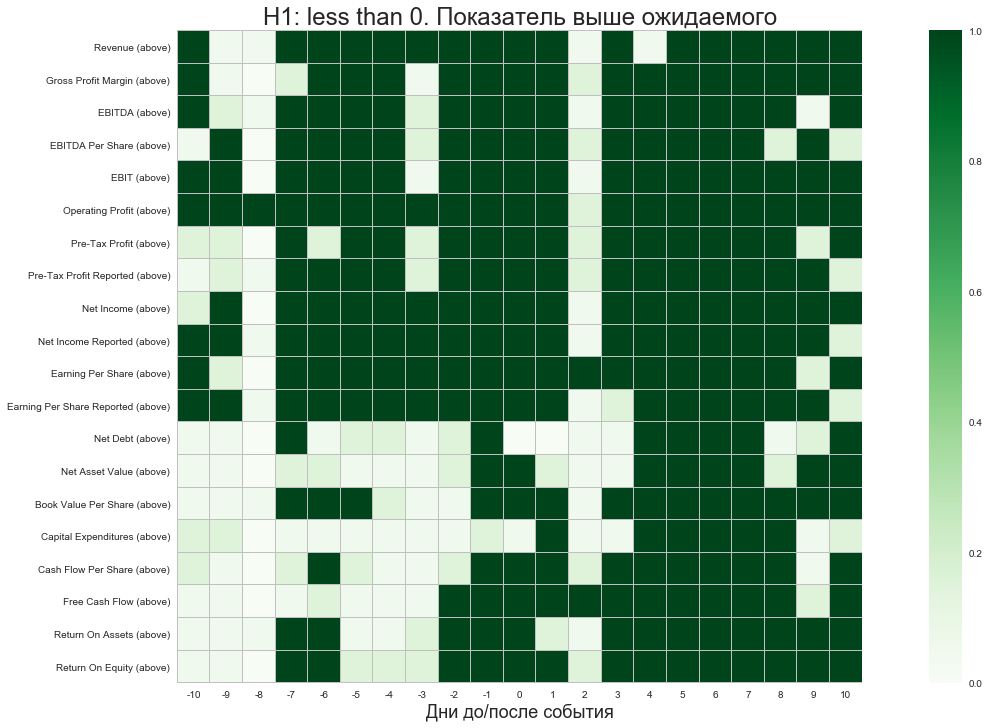

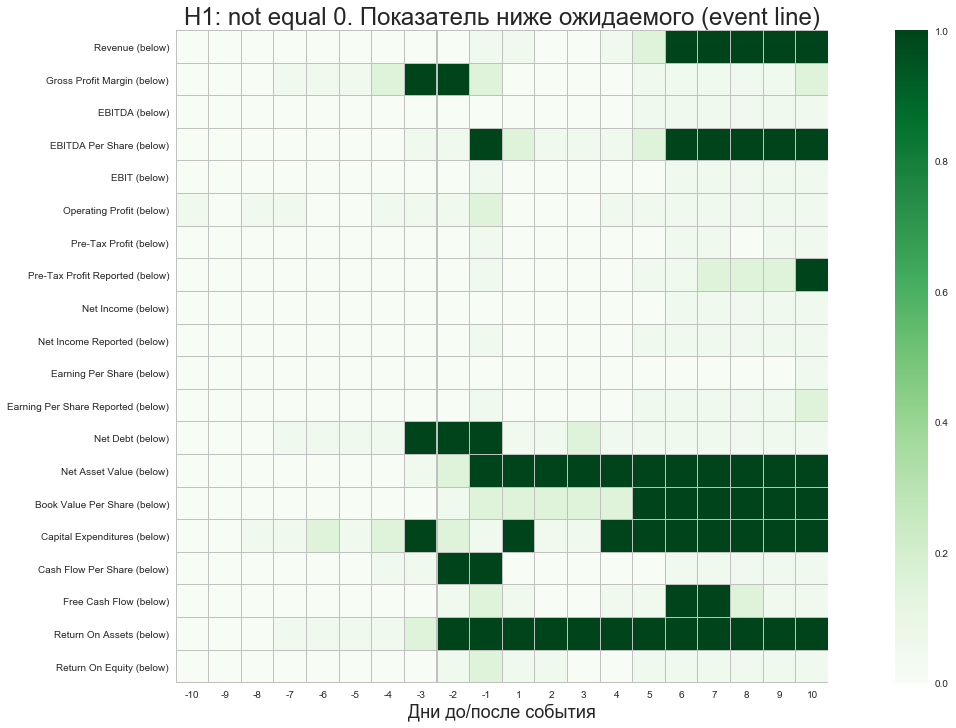

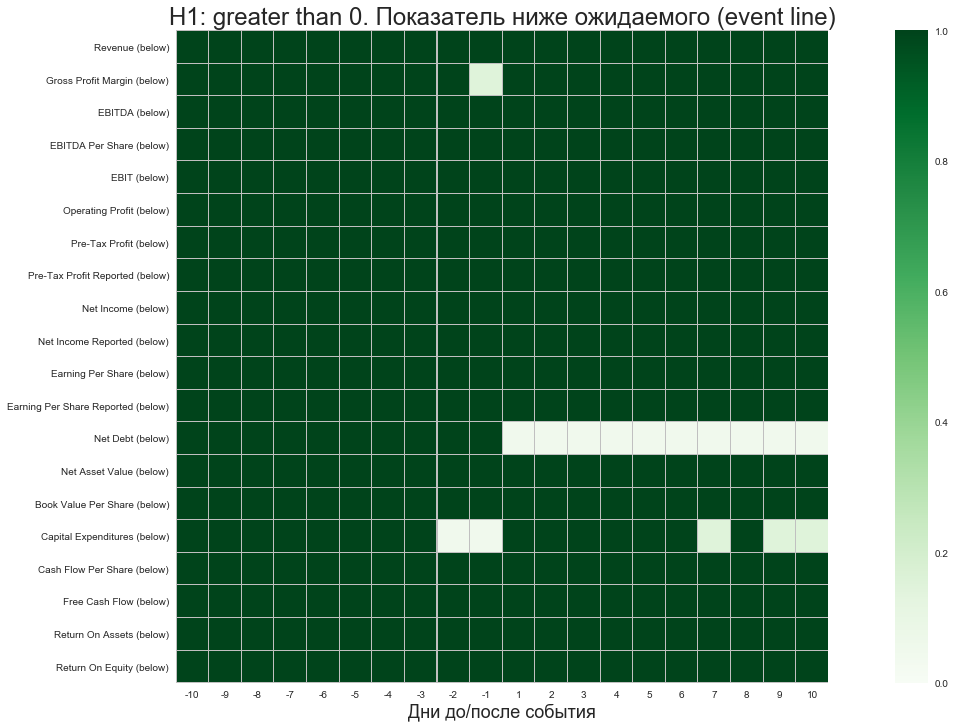

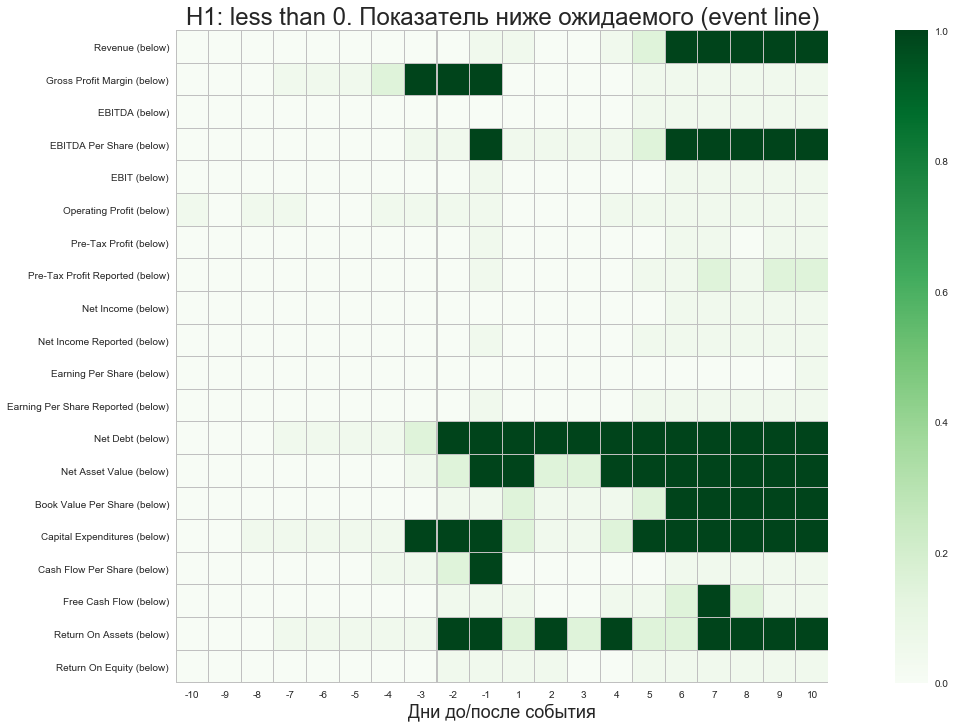

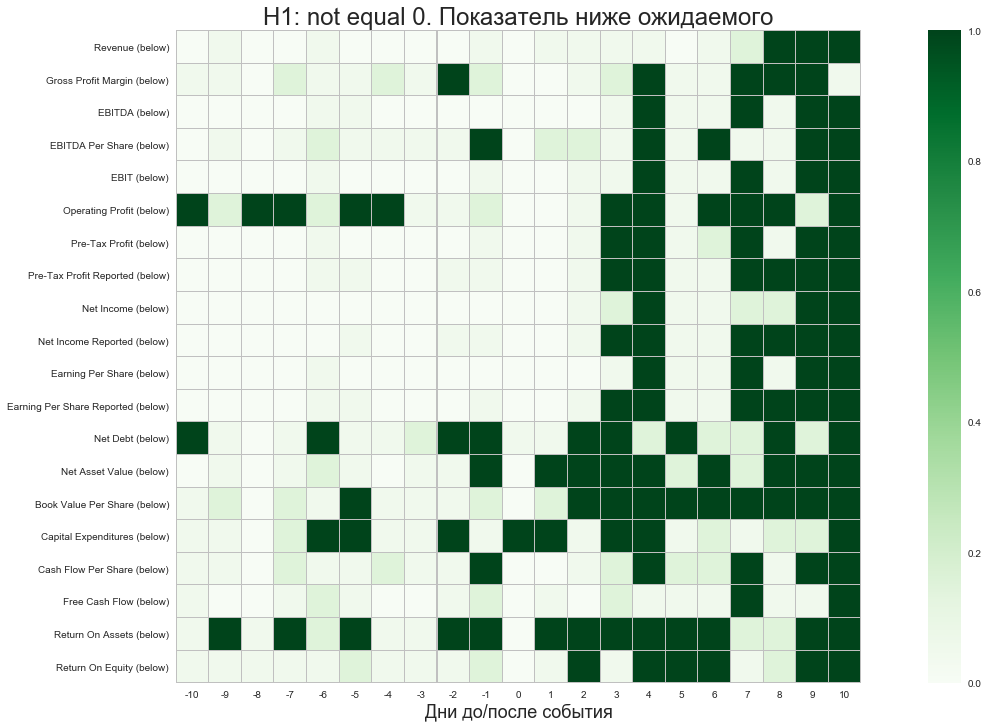

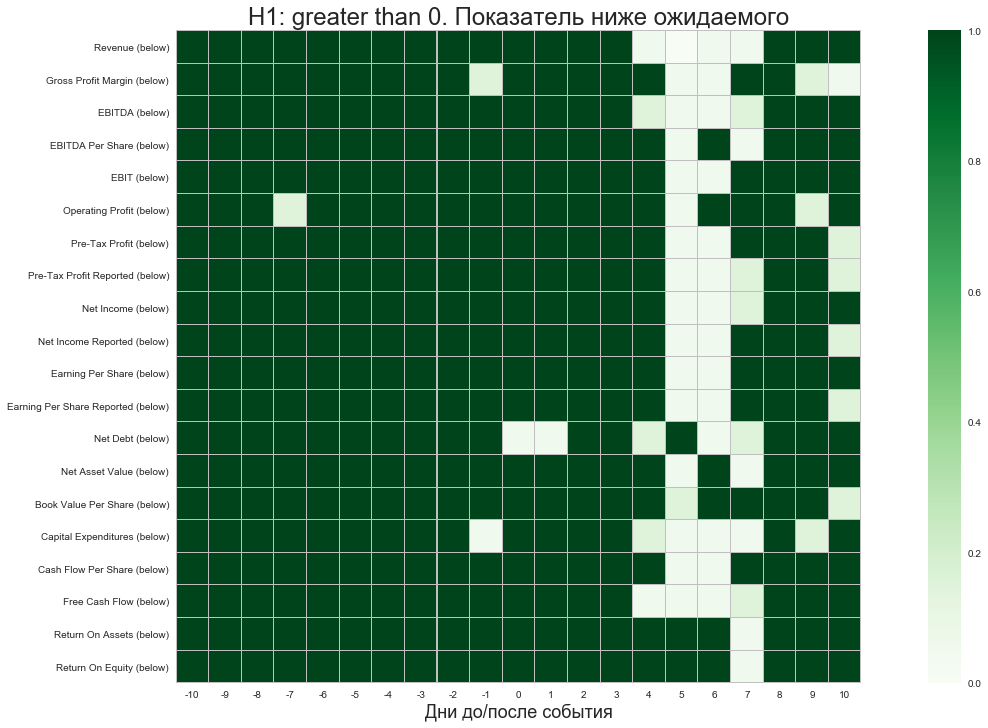

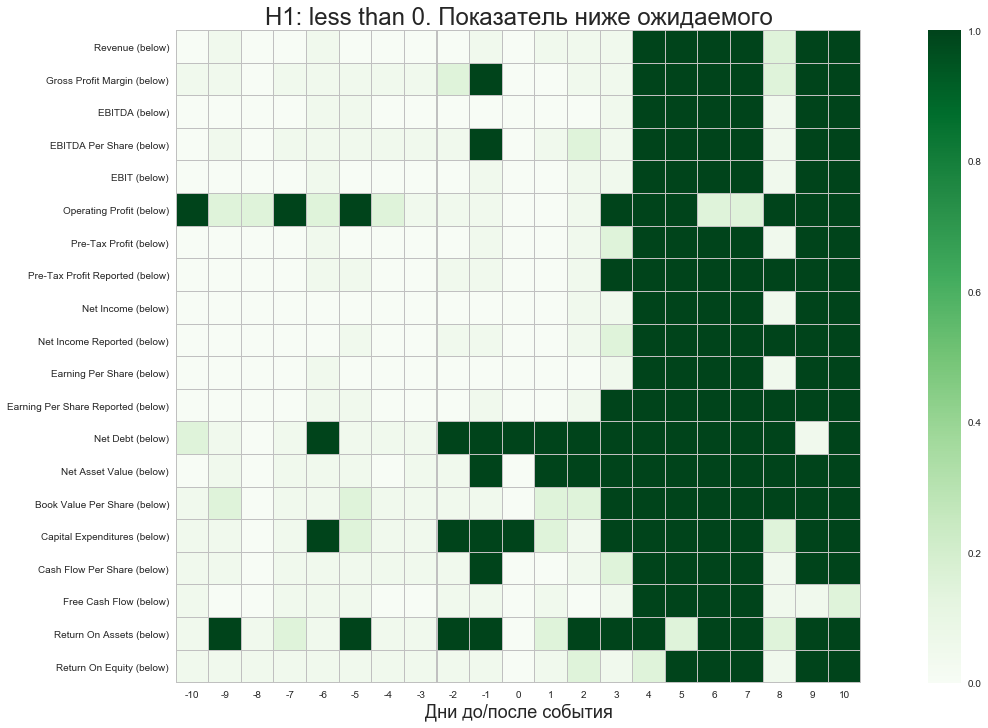

In [47]:
alpha  = [0., 0.05, 0.15]
#alpha = None
prename = './heatmaps/(Ab ret)'
savefig = True
cmap='Greens'

plot_heat(data = p_vals_event.iloc[::2,:].copy(), title = 'H1: not equal 0. Показатель выше ожидаемого (event line)',
          alpha = alpha, savefig = savefig, prename =prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_event_greater.iloc[::2,:].copy(), title = 'H1: greater than 0. Показатель выше ожидаемого (event line)',
          alpha = alpha, savefig = savefig, prename =prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_event_less.iloc[::2,:].copy(), title = 'H1: less than 0. Показатель выше ожидаемого (event line)',
          alpha = alpha, savefig = savefig, prename =prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);



plot_heat(data = p_vals.iloc[::2,:].copy(), title = 'H1: not equal 0. Показатель выше ожидаемого',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_greater.iloc[::2,:].copy(), title = 'H1: greater than 0. Показатель выше ожидаемого',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_less.iloc[::2,:].copy(), title = 'H1: less than 0. Показатель выше ожидаемого',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);



plot_heat(data = p_vals_event.iloc[1::2,:].copy(), title = 'H1: not equal 0. Показатель ниже ожидаемого (event line)',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_event_greater.iloc[1::2,:].copy(), title = 'H1: greater than 0. Показатель ниже ожидаемого (event line)',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_event_less.iloc[1::2,:].copy(), title = 'H1: less than 0. Показатель ниже ожидаемого (event line)',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);



plot_heat(data = p_vals.iloc[1::2,:].copy(), title = 'H1: not equal 0. Показатель ниже ожидаемого',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_greater.iloc[1::2,:].copy(), title = 'H1: greater than 0. Показатель ниже ожидаемого',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_less.iloc[1::2,:].copy(), title = 'H1: less than 0. Показатель ниже ожидаемого',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);